In [21]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "data_aeroscapes", data_nomi = "aeroscapes")

Dataset yuklab olingan. data_aeroscapes/aeroscapes papkasini ni tekshiring.


In [1]:
import torch, os, random, cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import albumentations as A
from PIL import Image
from matplotlib import pyplot as plt
from torch.nn import *
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T

In [2]:
def get_transformation(size):
    return [A.Compose([A.Resize(size, size),
                      A.HorizontalFlip(0.5),
                      A.GaussNoise(0.3),
                      A.VerticalFlip(0.5)],is_check_shapes =False),
                     A.Compose([A.Resize(size, size)], is_check_shapes =False )]
tr_trf, ts_trf = get_transformation(size = 320)
tr_trf, ts_trf

(Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
   HorizontalFlip(always_apply=0.5, p=0.5),
   GaussNoise(always_apply=False, p=0.5, var_limit=(0, 0.3), per_channel=True, mean=0),
   VerticalFlip(always_apply=0.5, p=0.5),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False),
 Compose([
   Resize(always_apply=False, p=1, height=320, width=320, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=False))

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations=None, im_type = [".jpg", ".jpeg", ".png"] ):
        super().__init__()
        self.transformations = transformations
        self.tensorsize = T.Compose([T.ToTensor()])
        self.im_path = sorted(glob(f"{root}/images/*[{i for i in im_type}]"))
        self.labels_path = sorted(glob(f"{root}/labels/*[{i for i in im_type}]"))
        print(len(self.im_path))
        print(len(self.labels_path))
        

    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):
        
        im = cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
        gt = cv2.cvtColor(cv2.imread(self.labels_path[idx]), cv2.COLOR_BGR2GRAY)
                          
        if self.transformations is not None:
                          
             transform = self.transformations(image = im, mask = gt)
             im = transform['image']
             gt =transform["mask"]

        im = self.tensorsize(im)
        gt = torch.tensor(gt>2).long()
        return im, gt

data = "data_aeroscapes/aeroscapes/aerospaces"
ds = CustomDataset(root =data, transformations=tr_trf)
im, gt = ds[0]
print(np.unique(gt))
print(type(gt))
print(gt.shape)

3269
3269
[0 1]
<class 'torch.Tensor'>
torch.Size([320, 320])


In [4]:
def get_dlr(root, transformations, bs, split =[0.8, 0.1, 0.1]):
    ds = CustomDataset(root = root, transformations=transformations)
    ds_len = len(ds)
  
    tr_len =int(split[0]*ds_len)
    val_len =int(split[1]*ds_len)
    ts_len = ds_len-(tr_len+val_len)
    
    tr_ds, val_ds, ts_ds = random_split(ds,[tr_len, val_len, ts_len])
    
    
    print(len(tr_ds))
    print(len(val_ds))
    print(len(ts_ds))
    
    tr_dl = DataLoader(tr_ds, batch_size =bs, shuffle =True, num_workers =0)
    val_dl = DataLoader(val_ds, batch_size =bs, shuffle =True, num_workers =0)
    ts_dl = DataLoader(ts_ds, batch_size =1, shuffle =False, num_workers =0)
    return tr_dl, val_dl, ts_dl

    
tr_dl, val_dl, ts_dl = get_dlr(root = "data_aeroscapes/aeroscapes/aerospaces", transformations= ts_trf, bs = 16 ) 

3269
3269
2615
326
328


In [5]:
for idx, batch in enumerate(tr_dl.dataset):
    if idx == 1: break
    im, gt =batch
    print(gt.squeeze(0).shape)

torch.Size([320, 320])


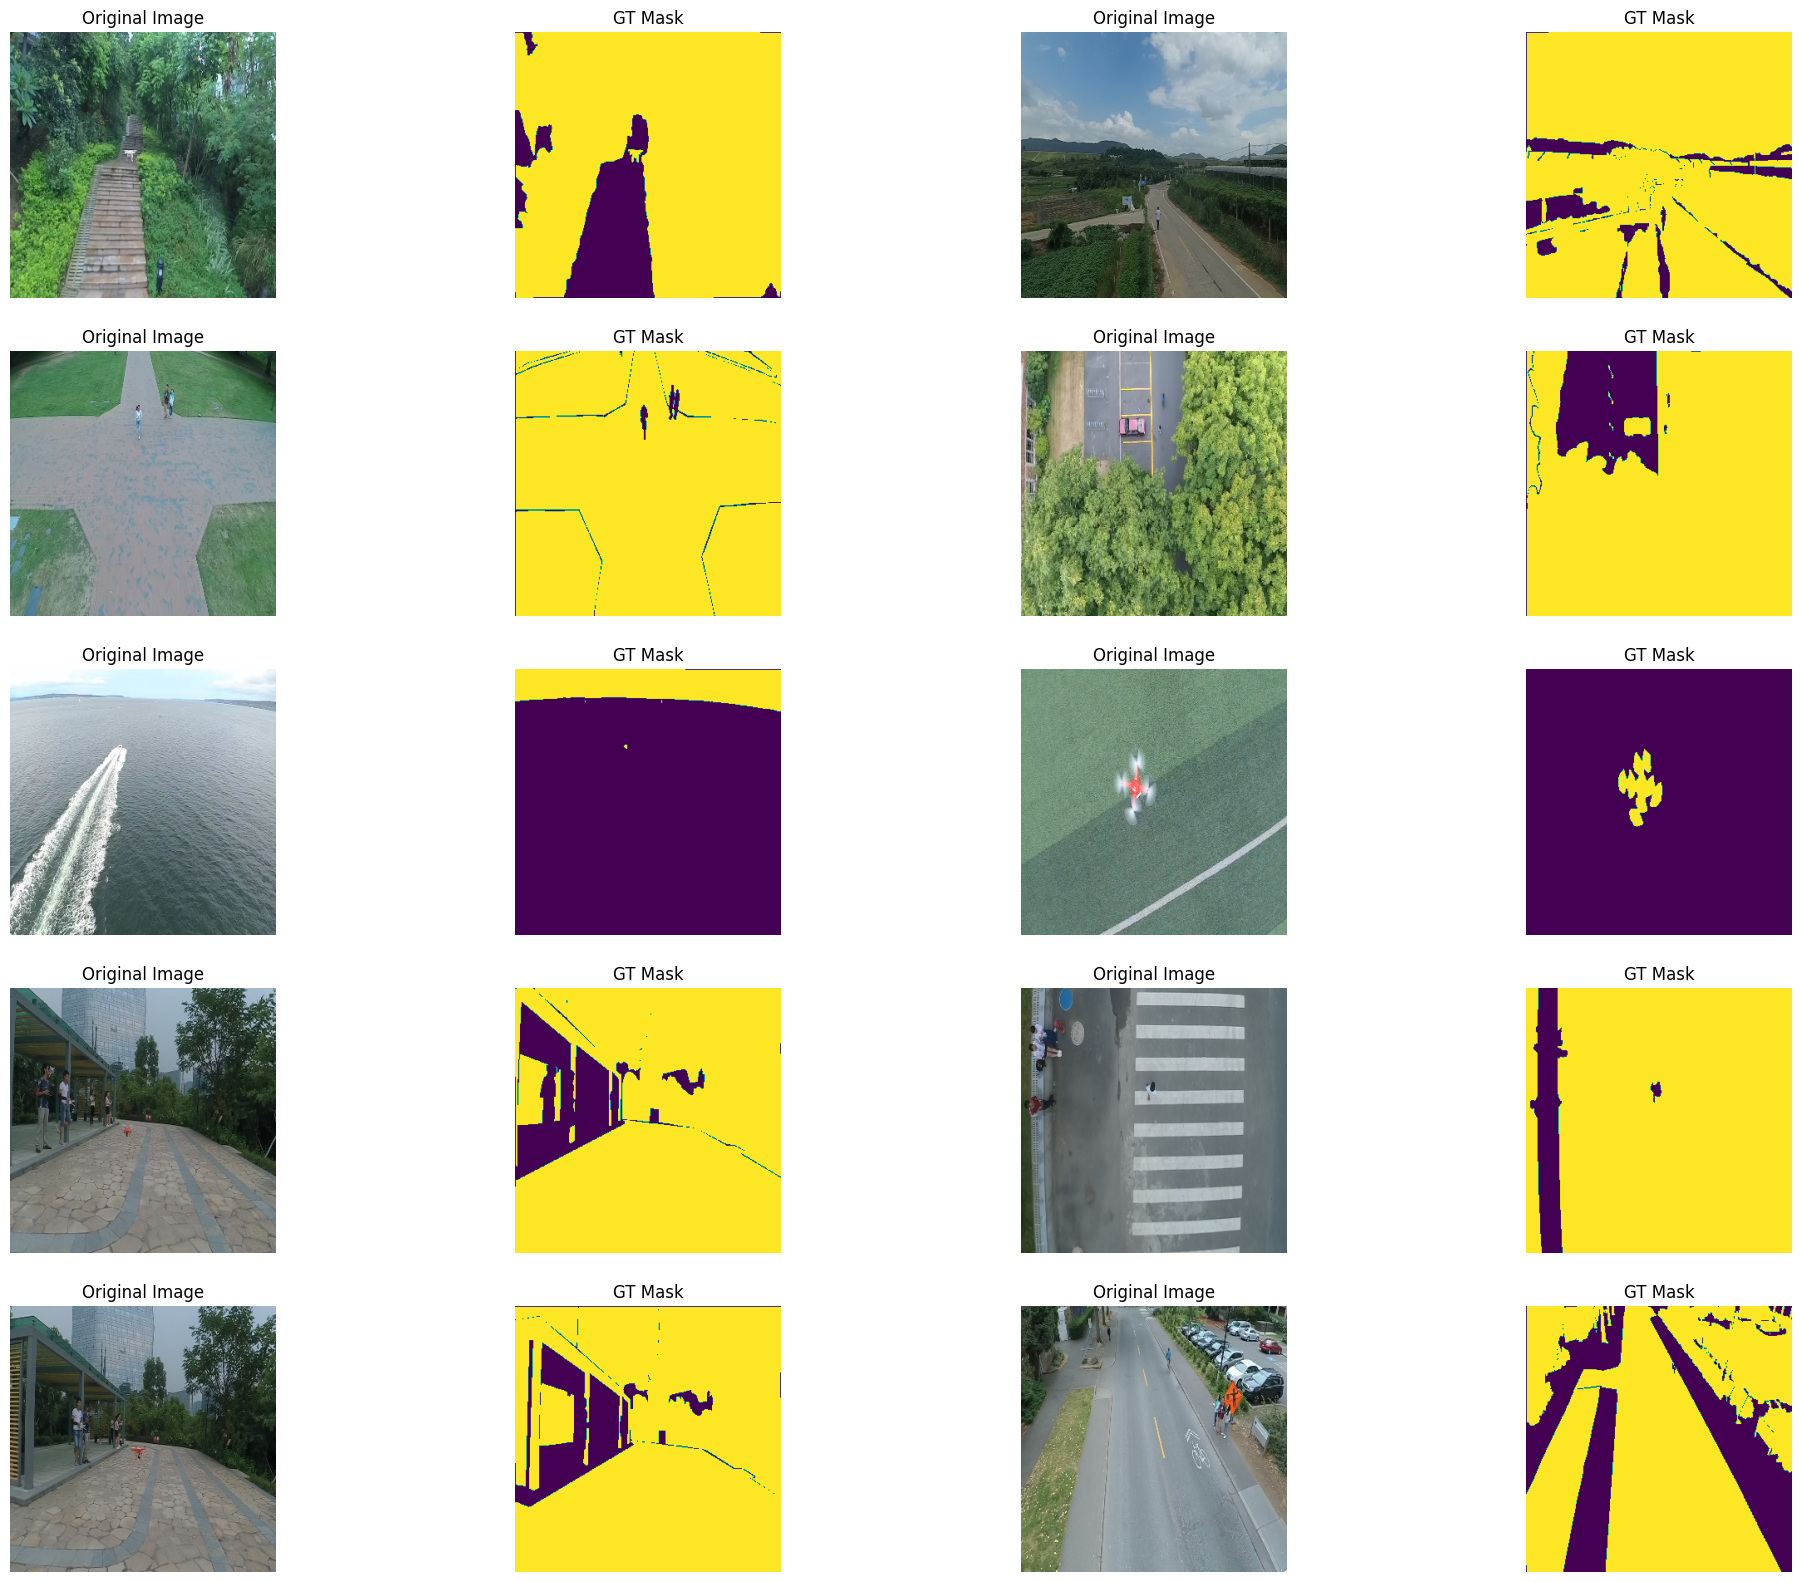

In [6]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8"))
    plt.axis("off"); plt.title(title)     
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indexs = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indexs):
        
        if count == n_ims + 1: break
        
        im, gt = ds[index]
    
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt.squeeze(0), gt = True, title = "GT Mask")
        
visualize(tr_dl.dataset, n_ims = 20)

In [7]:

model = smp.Unet(encoder_name='resnet18', classes=2, encoder_depth=5,
                 encoder_weights='imagenet', activation=None, decoder_channels=[256,128,64,32,16])
model

loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class Metrics():
    def __init__(self, pred, gt, loss_fn, eps =3e-4, number_class = 2):
        
        self.pred = torch.argmax(torch.nn.functional.softmax(pred, dim =1), dim =1)
    
        self.pred_ = pred
        self.gt = gt
        self.loss_fn = loss_fn
        self.eps = eps
        self.number_class = number_class

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    # PA
    def PA(self):
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum())/float(match.numel())
        
     # mIoU
    def mioU(self):
        pred, gt =self.to_contiguous(self.pred), self.to_contiguous(self.gt) 
        Iou_class = []
        for a in range(self.number_class):
            match_pred = pred ==a
            match_gt =gt==a
            if match_gt.long().sum().item()==0: Iou_class.append(np.nan)
            else:
                intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                union = torch.logical_or(match_pred, match_gt).sum().float().item()

                iou = (intersection)/(union+self.eps)
                Iou_class.append(iou)

            return np.nanmean(Iou_class)
    
    def loss(self):
        
        return self.loss_fn(self.pred_, self.gt)
            


In [9]:
def train(model, tr_dlr, val_dlr, epochs, device, loss_fn, opt, save_prefix):
        
    tr_loss, tr_pa, tr_iou =[],[],[]
    val_loss, val_pa, val_iou =[],[],[]
    tr_len, val_len = len(tr_dlr), len(val_dlr)
    
    
    best_loss = np.inf
    os.makedirs("save_aerospaces_best_model", exist_ok=True)
    model.to(device)
        
    print("Train is starting ....")
    for epoch in range(epochs):
        tr_losses, tr_pas, tr_ious =0,0,0
        model.train()
        print(f"{epoch+1} - epoch is starting")
        for idx, batch in enumerate(tqdm(tr_dlr)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            met = Metrics(pred, gt, loss_fn)
            
            losses =met.loss()
            
            tr_ious+=met.mioU()
            tr_pas +=met.PA()
            tr_losses+=losses.item()
            
            opt.zero_grad()
            losses.backward()
            opt.step()
        print(f"{epoch+1} - epoch validation starting....")
        model.eval()
        val_losses, val_pas, val_ious =0,0,0
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dlr)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)
                
                met = Metrics(pred, gt, loss_fn)
                
                val_losses+=met.loss().item()
                val_pas +=met.PA()
                val_ious+=met.mioU()
                
        print(f"{epoch+1} - epoch train finished")
        
        tr_ious /=tr_len
        tr_pas /= tr_len
        tr_losses/= tr_len
        
        val_ious /=val_len
        val_pas /= val_len
        val_losses /= val_len
        print("\n ------------------------------------------")
        print(f"{epoch+1} - epoch train result: \n")
        print(f"Train loss                 --> {tr_losses:.3f}")
        print(f"Train PA                   --> {tr_pas:.3f}")
        print(f"Train mIoU                 --> {tr_ious:.3f}\n")
        print(f"{epoch+1} - epoch validayion result: \n")
        print(f"Validation loss             --> {val_losses:.3f}")
        print(f"Validation PA               --> {val_pas:.3f}")
        print(f"Validation mIoU             --> {val_ious:.3f}")
        
        
        tr_loss.append(tr_losses)
        tr_pa.append(tr_pas)
        tr_iou.append(tr_ious)
        val_loss.append(val_losses)
        val_pa.append(val_pas)
        val_iou.append(val_ious)
        
        if val_losses < best_loss:

            best_loss = val_losses
            
            print(f"The model with the lowest error is saved")
            torch.save(model, f"save_aerospaces_best_model/{save_prefix}_best_model.pt")
                    
    return {"tr_loss": tr_loss,"tr_pa": tr_pa, "tr_iou": tr_iou,
               "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou}
        
    
result =train(model = model, tr_dlr = tr_dl, val_dlr = val_dl, epochs = 10,
              device = device, loss_fn = loss_fn, opt = optimizer, save_prefix = "aerospaces")    

Train is starting ....
1 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [01:04<00:00,  2.55it/s]


1 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.71it/s]


1 - epoch train finished

 ------------------------------------------
1 - epoch train result: 

Train loss                 --> 0.273
Train PA                   --> 0.886
Train mIoU                 --> 0.604

1 - epoch validayion result: 

Validation loss             --> 0.269
Validation PA               --> 0.890
Validation mIoU             --> 0.549
The model with the lowest error is saved
2 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:49<00:00,  3.30it/s]


2 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.26it/s]


2 - epoch train finished

 ------------------------------------------
2 - epoch train result: 

Train loss                 --> 0.155
Train PA                   --> 0.939
Train mIoU                 --> 0.759

2 - epoch validayion result: 

Validation loss             --> 0.114
Validation PA               --> 0.954
Validation mIoU             --> 0.794
The model with the lowest error is saved
3 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:49<00:00,  3.32it/s]


3 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.29it/s]


3 - epoch train finished

 ------------------------------------------
3 - epoch train result: 

Train loss                 --> 0.126
Train PA                   --> 0.951
Train mIoU                 --> 0.802

3 - epoch validayion result: 

Validation loss             --> 0.102
Validation PA               --> 0.960
Validation mIoU             --> 0.824
The model with the lowest error is saved
4 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:49<00:00,  3.32it/s]


4 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.16it/s]


4 - epoch train finished

 ------------------------------------------
4 - epoch train result: 

Train loss                 --> 0.102
Train PA                   --> 0.961
Train mIoU                 --> 0.838

4 - epoch validayion result: 

Validation loss             --> 0.115
Validation PA               --> 0.954
Validation mIoU             --> 0.809
5 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:54<00:00,  3.04it/s]


5 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.12it/s]


5 - epoch train finished

 ------------------------------------------
5 - epoch train result: 

Train loss                 --> 0.098
Train PA                   --> 0.963
Train mIoU                 --> 0.843

5 - epoch validayion result: 

Validation loss             --> 0.098
Validation PA               --> 0.961
Validation mIoU             --> 0.825
The model with the lowest error is saved
6 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:50<00:00,  3.24it/s]


6 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.27it/s]


6 - epoch train finished

 ------------------------------------------
6 - epoch train result: 

Train loss                 --> 0.080
Train PA                   --> 0.969
Train mIoU                 --> 0.869

6 - epoch validayion result: 

Validation loss             --> 0.083
Validation PA               --> 0.967
Validation mIoU             --> 0.840
The model with the lowest error is saved
7 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:49<00:00,  3.30it/s]


7 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.30it/s]


7 - epoch train finished

 ------------------------------------------
7 - epoch train result: 

Train loss                 --> 0.065
Train PA                   --> 0.975
Train mIoU                 --> 0.892

7 - epoch validayion result: 

Validation loss             --> 0.075
Validation PA               --> 0.970
Validation mIoU             --> 0.868
The model with the lowest error is saved
8 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:50<00:00,  3.25it/s]


8 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.20it/s]


8 - epoch train finished

 ------------------------------------------
8 - epoch train result: 

Train loss                 --> 0.061
Train PA                   --> 0.976
Train mIoU                 --> 0.894

8 - epoch validayion result: 

Validation loss             --> 0.071
Validation PA               --> 0.972
Validation mIoU             --> 0.869
The model with the lowest error is saved
9 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:50<00:00,  3.25it/s]


9 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.05it/s]


9 - epoch train finished

 ------------------------------------------
9 - epoch train result: 

Train loss                 --> 0.057
Train PA                   --> 0.978
Train mIoU                 --> 0.904

9 - epoch validayion result: 

Validation loss             --> 0.067
Validation PA               --> 0.974
Validation mIoU             --> 0.875
The model with the lowest error is saved
10 - epoch is starting


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:50<00:00,  3.24it/s]


10 - epoch validation starting....


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.20it/s]


10 - epoch train finished

 ------------------------------------------
10 - epoch train result: 

Train loss                 --> 0.055
Train PA                   --> 0.979
Train mIoU                 --> 0.906

10 - epoch validayion result: 

Validation loss             --> 0.066
Validation PA               --> 0.974
Validation mIoU             --> 0.878
The model with the lowest error is saved


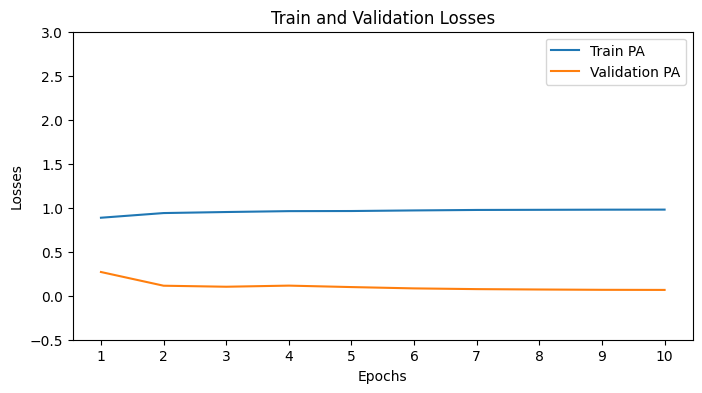

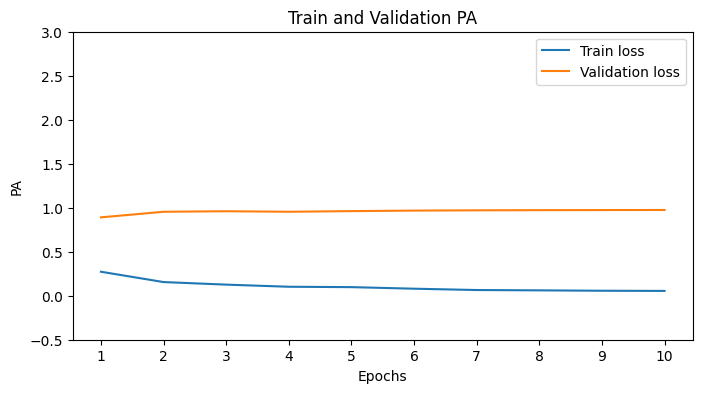

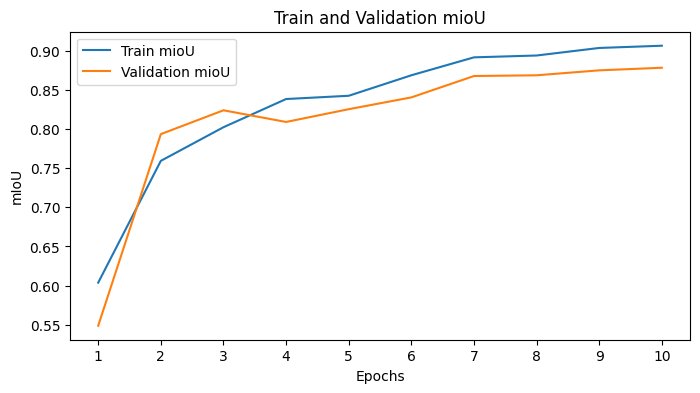

In [10]:
class plot():
    def __init__(self, r):
        plt.figure(figsize=(8,4))
        plt.plot(r["tr_pa"], label = "Train PA")
        plt.plot(r["val_loss"], label = "Validation PA")
        plt.title("Train and Validation Losses")
        plt.xticks(np.arange(len(r["val_loss"])), [i for i in range(1, len(r["val_loss"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.legend()
        plt.ylim(-0.5, 3)
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(r["tr_loss"], label = "Train loss")
        plt.plot(r["val_pa"], label = "Validation loss")
        plt.title("Train and Validation PA")
        plt.xticks(np.arange(len(r["val_loss"])), [i for i in range(1, len(r["val_loss"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("PA")
        plt.ylim(-0.5, 3)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(8,4))
        plt.plot(r["tr_iou"], label = "Train mioU")
        plt.plot(r["val_iou"], label = "Validation mioU")
        plt.title("Train and Validation mioU")
        plt.xticks(np.arange(len(r["val_loss"])), [i for i in range(1, len(r["val_loss"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("mIoU")
        plt.legend()
        plt.show()
plot(result)

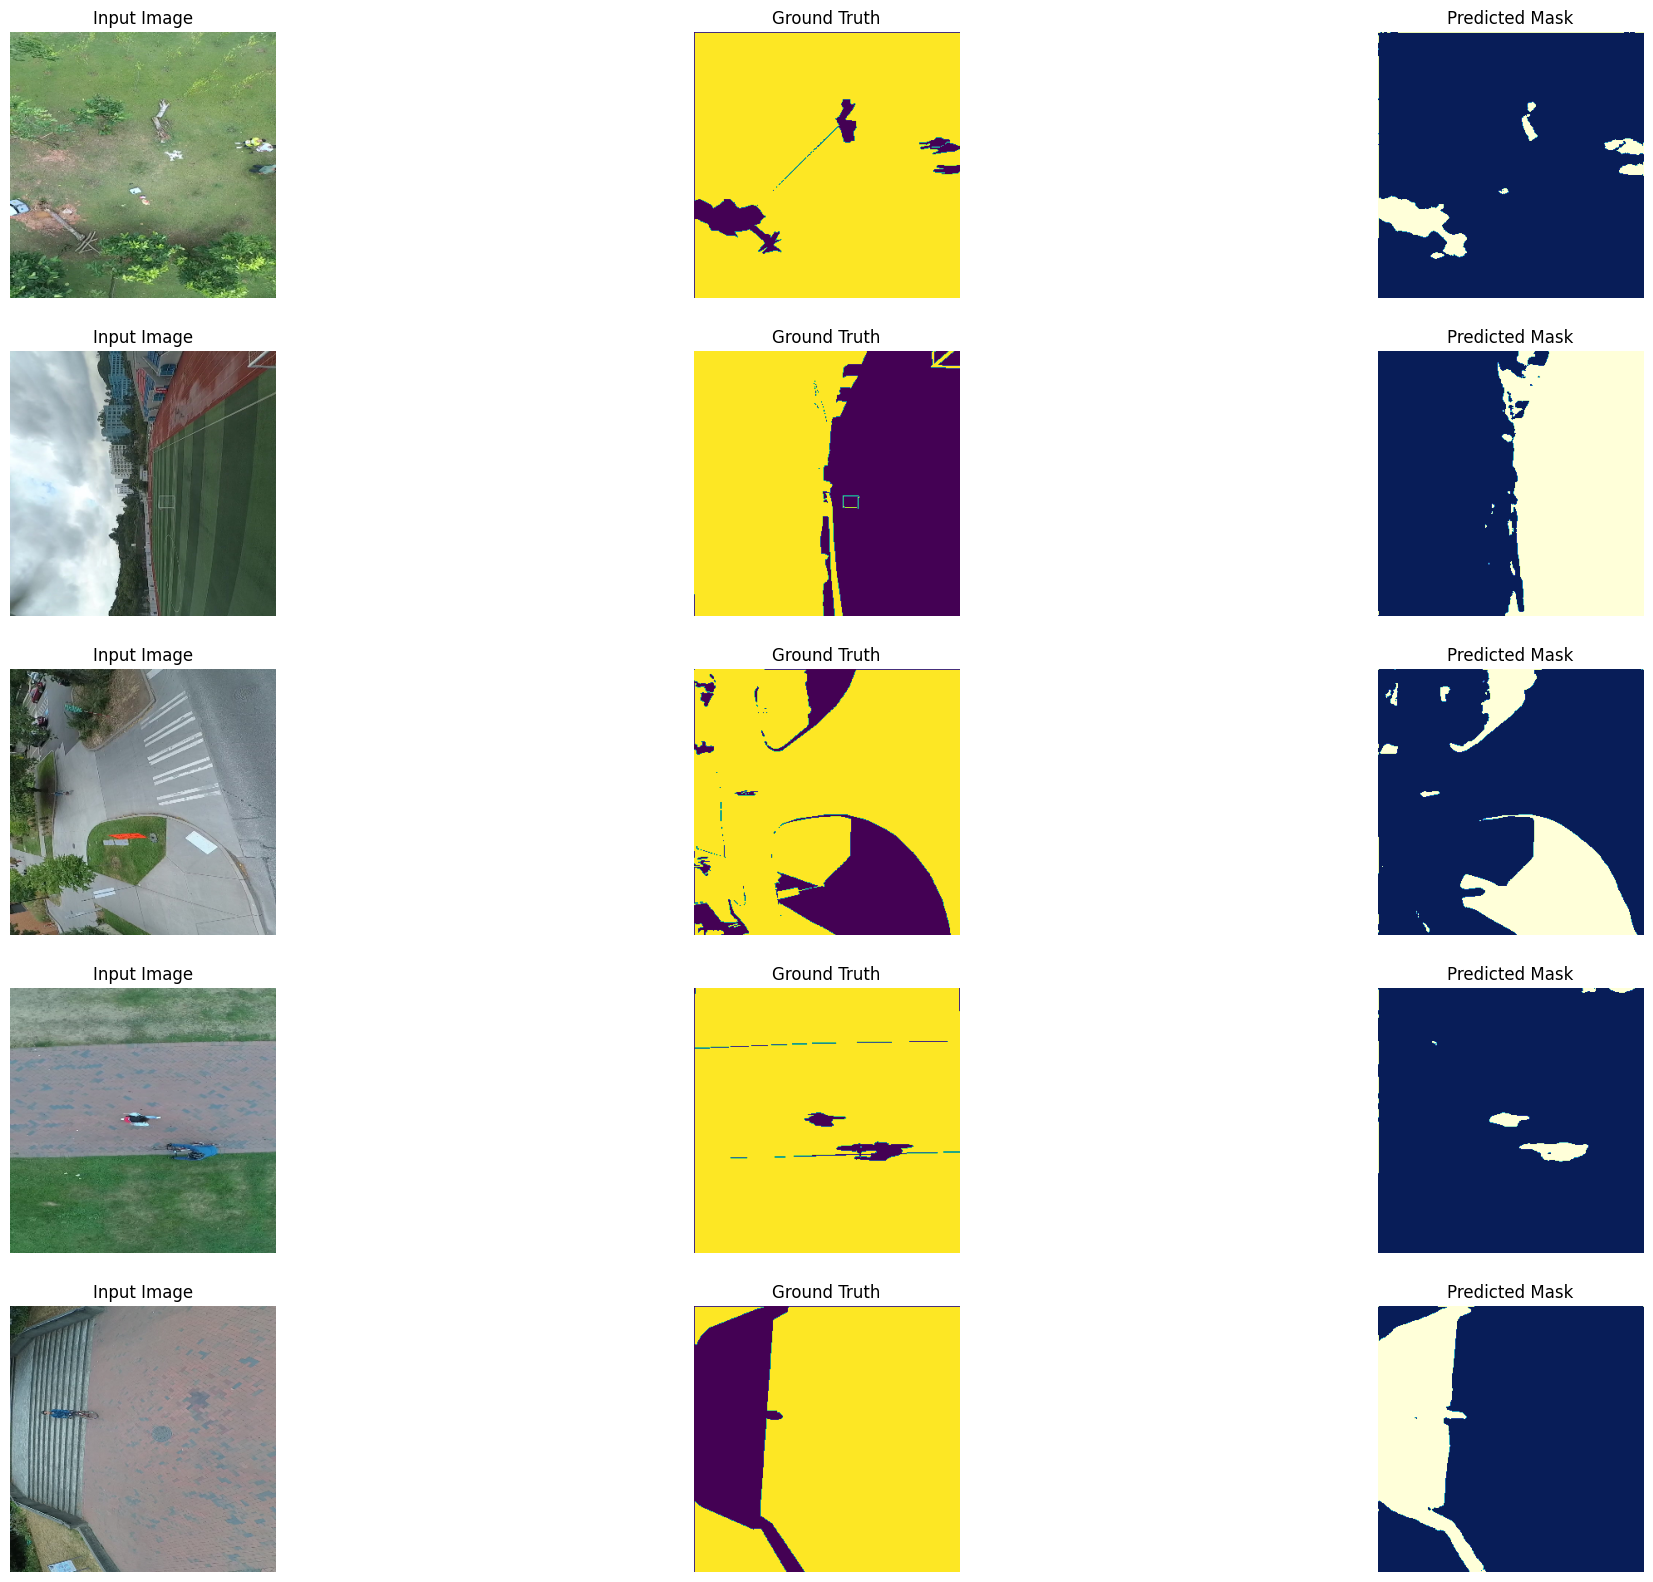

In [11]:
def inference(dl, model, device, n_ims=15):
    cols = 3
    rows = (n_ims + cols - 1) // cols  # Adjusted rows calculation

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data
        # Get predicted mask
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
        ims.append(im.cpu().numpy())
        gts.append(gt.cpu().numpy())
        preds.append(pred.cpu().numpy())

    plt.figure(figsize=(25, 20))
    while count <= n_ims:  # Adjusted loop condition
        for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
            # print(pred.squeeze(0).shape)
            # print(pred.shape)
            # print(pred.shape)
            if count > n_ims:
                break
            plt.subplot(rows, cols, count)
            
            plt.imshow(im.squeeze(0).transpose(2, 1, 0))
            plt.title("Input Image")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(gt.transpose(2, 1, 0))
        
            plt.title("Ground Truth")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(pred.transpose(2, 1, 0), cmap = 'YlGnBu')
            plt.title("Predicted Mask")
            plt.axis('off')
            count += 1

    plt.show()

# Assuming ts_dl is from test dataloader
model = torch.load("save_aerospaces_best_model/aerospaces_best_model.pt")
inference(ts_dl, model=model, device=device)
